In [25]:
import sys
sys.path.append('../code/') 
import mocap_functions
from functools import partial
import numpy as np
import pandas as pd
import neo
import matplotlib.pyplot as plt
import scipy.io as sio
import pickle
import quantities as pq
import simnets
from sklearn.cluster import KMeans


In [2]:
data_path = '../data/SPK20220308/task_data/'

# read python dict back from the file
cb_dict_file = open(data_path + 'cb_dict.pkl', 'rb')
cb_dict = pickle.load(cb_dict_file)
cb_dict_file.close()

In [3]:
experiment_dict = cb_dict['cb1']['experiment_dict']

experiment_dict_corrected = sio.loadmat(f'{data_path}eventsCB1_corrected.mat')
ev_ex_corrected = experiment_dict_corrected['eventsCB1']

#Load variables from struct (struct indexing is unfortunately hideous)
ev_ex = experiment_dict['df']
tgtON = ev_ex['tgtON_C'][0][0][0]
gocON = ev_ex['gocON_C'][0][0][0]
#gocOFF = ev_ex['gocOFF'][0][0][0]
#stmv = ev_ex['stmv'][0][0][0]
contact = ev_ex['contact_C'][0][0][0]
endhold = ev_ex['endhold_C'][0][0][0]
layout = ev_ex_corrected['LAYOUT_C'][0][0][0]
position = ev_ex_corrected['POSITION_C'][0][0][0]
#reward = ev_ex['reward'][0][0][0]
#error = ev_ex['error'][0][0][0]

In [8]:
# Find scale/timeshift between CB1 and CB2
cb2_align_ts = cb_dict['cb2']['experiment_dict']['df']['gocON_C'][0][0][0]
assert len(cb2_align_ts) == len(gocON) 
cb2_start, cb2_end = cb2_align_ts[0], cb2_align_ts[-1]

ts_shift = gocON[0] - cb2_start 
ts_scale = (cb2_end - cb2_start) / (gocON[-1] -  gocON[0])

unit_timestamps = cb_dict['cb1']['unit_timestamps'].copy()

# Shift and scale time stamps between the two machines
unit_timestamps_cb2 = cb_dict['cb2']['unit_timestamps'].copy()
unit_timestamps_cb2_corrected = dict()
for unit_idx, unit_ts in unit_timestamps_cb2.items():
    ts_corrected = (unit_ts + ts_shift * (pq.s)) / (ts_scale * pq.s)
    unit_timestamps_cb2_corrected[unit_idx] = ts_corrected


unit_timestamps.update(unit_timestamps_cb2_corrected)


In [9]:
unit_timestamps_list = [ts for ts in unit_timestamps.values()]

In [45]:
st_data = mocap_functions.st_window_split(unit_timestamps_list, event_times=gocON * pq.s, wstart=0 * pq.s, wstop=0.3 * pq.s)
projection_args = {'n_components': 2, 'perplexity': 9, 'learning_rate': 5, 'random_state': 0}
st_args = (200,)

In [46]:
model = simnets.SIMNETS(st_dist='victor-purpura', unit_dist='euclidean', projection='TSNE')
model.fit(st_data, st_args=st_args, projection_args=projection_args)


/home/ntolley/anaconda3/lib/python3.9/site-packages/numba/core/ir_utils.py:2152: NumbaPendingDeprecationWarning: 
Encountered the use of a type that is scheduled for deprecation: type 'reflected list' found for argument 'unit_data' of function 'SIMNETS._make_trial_func.<locals>.TrialSimilarityMatrix'.

For more information visit https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-reflection-for-list-and-set-types

File "../../SIMNETS-Python/simnets/simnets_.py", line 139:
        @numba.njit()
        def TrialSimilarityMatrix(unit_data, st_args=None):
        ^

  warnings.warn(NumbaPendingDeprecationWarning(msg, loc=loc))
/home/ntolley/anaconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(


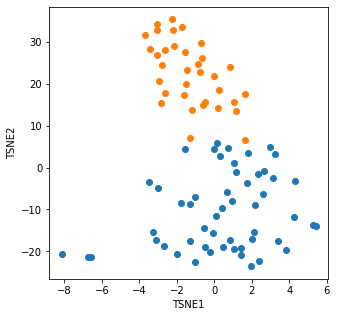

In [47]:
num_clusters = 2
cluster_pts = KMeans(n_clusters=num_clusters).fit_predict(model.points)

color_map = ['C0', 'C1', 'C2', 'C3', 'C4']
plt.figure(figsize=(5,5))
for cluster_idx in range(num_clusters):
    cluster_mask = cluster_pts == cluster_idx
    plt.scatter(model.points[cluster_mask, 0], model.points[cluster_mask, 1], color=color_map[cluster_idx])
    plt.xlabel('TSNE1')
    plt.ylabel('TSNE2')

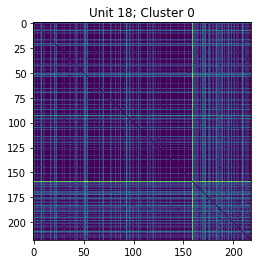

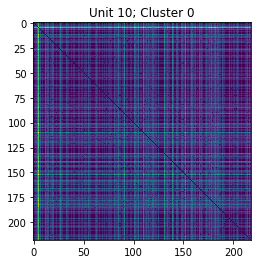

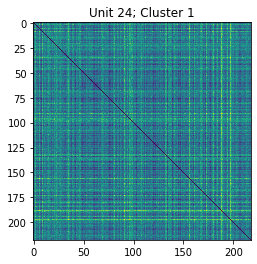

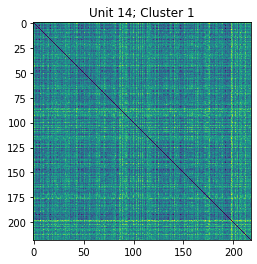

In [48]:
plot_units = [10, 5]

plot_clusters = [0, 1]

unit_indices = list()
for cluster_idx in plot_clusters:
    for plot_unit in plot_units:
        cluster_units = np.where(cluster_pts == cluster_idx)[0]
        unit_idx = cluster_units[plot_unit]
        unit_indices.append(unit_idx)
        trial_sim = model.trial_sim[unit_idx].reshape(model.num_trials, model.num_trials)
        plt.figure()
        plt.imshow(trial_sim)
        plt.title(f'Unit {unit_idx}; Cluster {cluster_idx}')
       
